#  Numerical Examples: The Karplus-Strong Algorithm (Python)

Let's explore the Python code implementing the equation

$y[n]=αy[n−M]+x[n]$,

where $x[n]$ is the input signal, $M$ is the delay, and $α$ is the decay. We assume that the value of the delay $M$ is equal to the length of the input signal $x$. In words, it is like filling the delay buffer and then recursively going over it. Additionally, we set the length of the output to be a multiple of the delay $M$ (i.e., of the length of the input signal). This is controlled by the argument $D$, so that the output length is $D∗M$.

### Direct implementation

A simple and intuitive approach is to use a for loop

In [1]:
def ks_loop(x, alpha, D):
    import numpy as np 
    ''' 
    Length of the output signal must be larger than the length of the input signal,
    that is, D must be larger than 1 
    '''
    if D < 1:
        print('Duration D must be greater than 1')
        
    # Make sure the input is a row-vector
    if x.ndim != 1:
        print('The array entered is of the wrong size')
        return None
    
    # Number of input samples
    M = len(x)
    
    # N umber of output samples
    size_y = D*M
    
    # Initialize with random input x
    y = np.zeros((size_y,1))
    for i in range(M):
        y[i] = x[i]
    
    for index in range(M,size_y):
        y[index] = float(alpha * y[index - M])
    
    return y

We can run the algorithm with the following input data: x randomly generated,

In [2]:
import numpy as np
x = np.random.randn(100)

(a noise burst of 100 samples), $α=0.9$, and $D=10$, i.e., an output signal of $10×100=1000$ samples. Note that this is good for visualization, but it will not sound good.

In [3]:
y = ks_loop(x, 0.9, 10)

The input looks like (plotted with pylab.stem)

Populating the interactive namespace from numpy and matplotlib


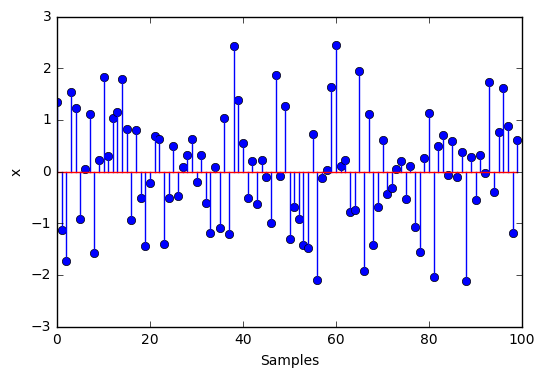

In [4]:
%pylab inline
stem(np.arange(x.size),x,)
xlabel('Samples')
ylabel('x')
show()

And the output is

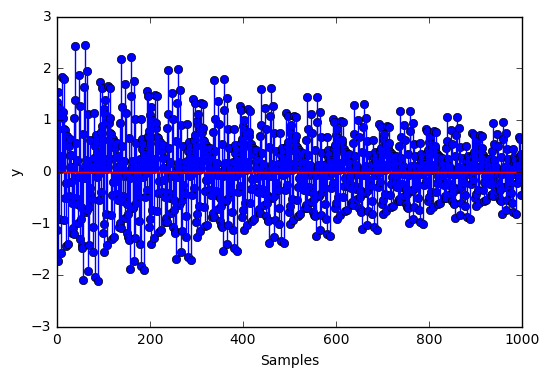

In [5]:
stem(np.arange(y.size),y)
xlabel('Samples')
ylabel('y')
show()

### Matrix implementation

Alternatively, the equation can be implemented using only matrix operations, thus optimizing the execution time. Given the total output length $N=M×D$, we create the following vectors and matrices. Their respective sizes are indicated in subscript.

$\alpha_{Vector} = \begin{pmatrix} 
1 \\ 
\alpha \\ 
\vdots \\ 
\alpha^{D-1} 
\end{pmatrix}_{D \times 1}$

$\alpha_{Matrix} = \begin{pmatrix}  
1 & \dots & 1 \\ 
\alpha & \cdots & \alpha \\  
\vdots & & \vdots \\ 
\alpha^{D-1}  & \cdots & \alpha^{D-1} 
\end{pmatrix}_{D\times M}$

$x_{Matrix} = \begin{pmatrix} 
x[1] & \cdots & x[M] \\ 
\vdots &  & \vdots \\ 
x[1] & \cdots & x[M] \\ 
\end{pmatrix}_{D \times M}$

$y_{Matrix}=\alpha_{Matrix}.∗x_{Matrix}=\begin{pmatrix} 
x[1] & \cdots & x[M] \\ 
\alpha x[1] & \cdots & \alpha x[M] \\ 
\vdots &  & \vdots \\ 
\alpha^{D-1} x[1] & \cdots & \alpha^{D-1} x[M] \\ 
\end{pmatrix}_{D\times M}$

In [6]:
def ks(x, alpha, D) :
    import numpy as np
    #   Length of the output signal must be larger than the length of the input signal,
    #   that is, D must be larger than 1 
    if D < 1:
        print('Duration D must be greater than 1')
        
    #   Make sure the input is a row-vector
    if x.ndim != 1:
        print('The array entered is of the wrong size')
        return None
    #   Number of input samples
    M = len(x)
    
    #   Create a vector of the powers of alpha, [alpha^0 alpha^1 ....]
    a = np.ones((1,D)) * alpha
    b = np.arange(D)
    alphaVector = pow(a,b)
    
    #Create a matrix with M columns, each being the vector of the powers of alpha
    alphaMatrix = np.eye(D,M) 
    for index in range(M):
        alphaMatrix[:,index] = alphaVector
        
    #Create a matrix with D rows filled by the input signal x  
    xMatrix = np.tile(x,(D,1))
    
    #Multipliy the two, so we can read it out
    #column-by-column
    yMatrix = alphaMatrix * xMatrix
    
    #Read out the output column by columnn
    y = yMatrix.flatten()
        
    return y

Of course, the result is the same, but the matrix based algorithm runs much faster.

### An example

Let's now play the guitar! We write a Python code that plays the opening chord of Hard day's night, a famous song by The Beatles.

In the Western system of music, A4 or middle A serves as reference with a frequency at 440Hz. The frequency of all other notes can be computed from it using the formula $f_0=440×2^{n/12}$ where n is the number of half-tones between A4 and the desired note. The exponent $n$ is positive if the note is above middle A, and negative otherwise.

The chord is composed of the following notes: D3, F3, G3, F4, A4, C5, G5. To give it a "wider" feeling we added another D2 below. Each note is generated using a separate Karplus-Strong algorithm. The resulting signals are added to form the chord. The original chord was played with 2 guitars (one of them 12-string and a bass guitar). We try to imitate differences in level by assigning a different gain to each note. Also, we sustain Paul's D note on the bass a bit longer by changing the corresponding decay factor.

To play a signal, we use the Python function scipy.io.wavfile.write(), and Audacity, which can take as arguments the signal to be played and the sampling frequency Fs.

We obtain the following implementation

In [7]:
# Parameters:
#
# - Fs       : sampling frequency
# - F0       : frequency of the notes forming chord
# - gain     : gains of individual notes in the chord
# - duration : duration of the chord in second
# - alpha    : attenuation in KS algorithm

Fs = 48000

import numpy as np
# D2, D3, F3, G3, F4, A4, C5, G5
F0 = 440*np.array([pow(2,(-31./12.)), pow(2,(-19./12.)), pow(2,(-16./12.)), pow(2,(-14./12.)), pow(2,(-4./12.)), 1, pow(2,(3./12.)), pow(2,(10./12.))])
gain = np.array([1.2, 3.0, 1.0, 2.2, 1.0, 1.0, 1.0, 3.5])
duration = 4
alpha = 0.9785

# Number of samples in the chord
nbsample_chord = Fs * duration

# This is used to correct alpha later, so that all the notes decay together
# (with the same decay rate)
first_duration = np.ceil(float(nbsample_chord)/round(float(Fs)/float(F0[0])))

# Initialization
chord = np.zeros(nbsample_chord)

for i in range(len(F0)):
    
    # Get M and duration parameter
    current_M = round(float(Fs)/float(F0[i]));
    current_duration = np.ceil(float(nbsample_chord)/float(current_M))
    
    # Correct current alpha so that all the notes decay together (with the
    # same decay rate)
    current_alpha = pow(alpha,(float(first_duration)/float(current_duration)))
    
    # Let Paul's high D on the bass ring a bit longer
    if i == 1:
        current_alpha = pow(current_alpha,8)
    
    # Generate input and output of KS algorithm
    x = np.random.rand(current_M)
    y = ks(x, current_alpha, current_duration)
    y = y[0:nbsample_chord]
    
    # Construct the chord by adding the generated note (with the
    # appropriate gain)
    chord = chord + gain[i] * y

import numpy as np
from scipy.io.wavfile import write

data = chord
scaled = np.int16(data/np.max(np.abs(data)) * 32767)

write('hard_days.wav', 44100, scaled)

C:\Users\usuario\Anaconda3\lib\site-packages\numpy\core\numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
C:\Users\usuario\Anaconda3\lib\site-packages\numpy\lib\twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
C:\Users\usuario\Anaconda3\lib\site-packages\numpy\lib\shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


Play the chord using a 48000 Hz sampling frequency, hear how it sounds!


In [8]:
import Audio
Audio.Audio(data=data, rate=48000, embed=True)

ImportError: No module named 'Audio'